# 3D Computer Vision (2023/24)

## Exercise 1

Submitted by Group xx: 
- Name1
- Name2
- Name3
- Name4

Upload: 08.11.2023 (11:30)

**Deadline**: 21.11.2023 (23:59)

Please hand in a single **.zip** file named according to the pattern "**groupXX_exerciseX**" (e.g. group00_exercise9). The contents of the .zip should be as follows:
- folder named according to the pattern groupXX_exerciseX
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

I.e.
1. **unzip** the provided exerciseX.zip file
2. **rename** folder "exerciseX" according to the pattern "groupXX_exerciseX"
3. **solve** tasks inside .ipynb file
4. **export** notebook as .html (File > Download as > HTML)
5. **zip** folder groupXX_exerciseX
6. **submit** groupXX_exerciseX.zip

## Theory

### T1. Camera with lenses

#### (a)
Given a camera with a distance $L$ between the film and the lens, derive the mathematical relationship (formula) between the height $H_o$ of the object in front of the camera and the height $H_i$ of its image. Additionally, explain the intuition behind the relationship. Assume a thin lens.

#### Solution
- Similar triangles:
$\frac{y'}{D'} =\frac{y}{D} $ $\rightarrow$ $\frac{H_i}{L} =\frac{H_o}{D}$
- therefore $\frac{H_i}{H_o} =\frac{L}{D}$
- Interpretation: 
    - For the same distance to the lense $D$, a bigger object ($H_o$) has a bigger image ($H_i$)
    - (OR) The further the object of height $H_o$ is away from the lense ($D$), the smaller is its image $H_i$

### T2. Rotation 
An Object is roated around the x-axis by $90°$, then around the y-axis by $270°$, and finally around the z-axis by $180°$.

#### (a)
Derive the 3D Roation Matrix that executes the same transformation.<br/>
*Hint: the given values lead to 'nice' numbers.*

#### Your answer goes here

#### (b)
Assume the object is a sphere with a radius of 3.5. Explain how the radius will change after the transformation. 

#### Your answer goes here

#### (c)
What is the rotation matrix that transforms the object back to its original orientation?<br/>
*Hint: this should be very short*

#### Your answer goes here

### T3. Transformation Chain

#### (a)
Why are homogeneous coordinates used for transforming points between coordinate systems?

#### Your answer goes here

#### (b)
Describe the transformation chain for mapping a point from the world coordinate system to the pixel coordinate system of an intrinsically and extrinsically calibrated camera.  Use formulas and explain the intermediate steps in words.

#### Your answer goes here

#### (c)
Describe the steps for modelling distortion. 

#### Your answer goes here

## Implementation

### I1. Distortion Modelling
The **./data/** directory contains images of a chessboard that were used for calibrating a camera with high radial distortion. The results of the calibration (intrinsics of the camera and extrinsics for each board) are stored in **./data/calib.mat**.

In [6]:
'''You can add all your imports here'''
import os

import numpy as np
import cv2 as cv
import scipy.io as io
from PIL import Image
import matplotlib.pyplot as plt

# scale_factor = 0.5

# I = cv.imread("data/00000.jpg", cv.IMREAD_GRAYSCALE)
# I_resized = cv.resize(I, (0, 0), fx=scale_factor, fy=scale_factor)

# plt.imshow(I_resized)

# num_columns = 9
# num_rows = 6

# board_size = [num_rows-1, num_columns-1]

# # Flags to findChessboardCorners that improve performance
# detect_flags = cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE + cv.CALIB_CB_FAST_CHECK

# ok, u = cv.findChessboardCorners(I, (board_size[0],board_size[1]), detect_flags)


#### (a)
Write a function that does the following:
- Draw any number of 2D pixel points onto an image

The inputs should be:
- A single image
- An Array of 2D pixel points
- Color of the points to be drawn

The output should be:
- An image with points drawn onto it

In [104]:
def draw_points(image, points, color):
    '''Draws points on an image'''
    for point in points:
        print("Center:", point)
        print("Center (tuple):", (point[0], point[1]))
        image = cv.circle(image, (int(point[0]), int(point[1])), 3, color)
    return image


# I = cv.imread("data/00000.jpg", cv.IMREAD_COLOR)
# draw_points(I, [(5, 5), (10, 10)], (0, 0, 255))

# # show image with matplotlib and correct color space
# plt.imshow(cv.cvtColor(I, cv.COLOR_BGR2RGB))


#### (b)
Write a function **project_points** that does the following:
- Convert 3D world points to 2D image points
- As an option: model radial distortions (using k1, k2, k5)

The inputs should be:
- Array of 3D world points
- Camera intrinsics
- Camera extrinsics
- Distortion coefficients (if needed)

The output should be:
- Array of 2D pixel coordinates

In [105]:
def project_points(point, K, R, t): 
    '''Projects a 3D point into the image plane'''
    print("R:", R)
    print("t:", t)
    print("K:", K)

    # Apply rotation
    X = R@point
    print ("point after rotation", X)

    # Apply extrinsics
    X = X + t.T
    print("point after translation", X)

    # Apply instrinsics
    X = K@X.T

    print("point after intrinsics", X)

    X = X.T

    X = X[0]
    X = [X[0]/ X[2], X[1]/X[2]]



    return X


#### (c)
Write a function **project_and_draw** that does the following:
- Execute **project_points**
- Execute **draw_points**
- Save the result as an image file

The inputs should be:
- The data that is necessary to run your functions
- Needs to run on **all images** with a single call

In [106]:
def project_and_draw(image, points, color, K, R, t):
  for point in points:
    print("point before projection", point)
    point = project_points(point, K, R, t)
    print("point after projection", point)
    image = draw_points(image, [point], color)
  return image


#### (d)
Run your **project_and_draw** function once without and once with distortion modelling. Then display the following:
- Your output for 00000.jpg **without any distortion modelling** in **red**
- Your output for 00000.jpg **with added radial distortion** (k1, k2, and k5) in **green**

[0.09  0.135 0.   ]
point before projection [0.   0.18 0.  ]
R: [[-0.89583257  0.05973068  0.44035923]
 [ 0.11463702  0.98844862  0.09913467]
 [-0.42935109  0.13928954 -0.89233181]]
t: [[ 0.04192682]
 [-0.21419555]
 [ 0.35270459]]
K: [[376.64067184   0.         320.57546504]
 [  0.         374.71731472 247.85562599]
 [  0.           0.           1.        ]]
point after rotation [0.01075152 0.17792075 0.02507212]
point after translation [[ 0.05267834 -0.0362748   0.37777671]]
point after intrinsics [[140.94674945]
 [ 80.04128647]
 [  0.37777671]]
point after projection [373.0953935659373, 211.87459372719954]
Center: [373.0953935659373, 211.87459372719954]
Center (tuple): (373.0953935659373, 211.87459372719954)
point before projection [0.045 0.18  0.   ]
R: [[-0.89583257  0.05973068  0.44035923]
 [ 0.11463702  0.98844862  0.09913467]
 [-0.42935109  0.13928954 -0.89233181]]
t: [[ 0.04192682]
 [-0.21419555]
 [ 0.35270459]]
K: [[376.64067184   0.         320.57546504]
 [  0.         374.71

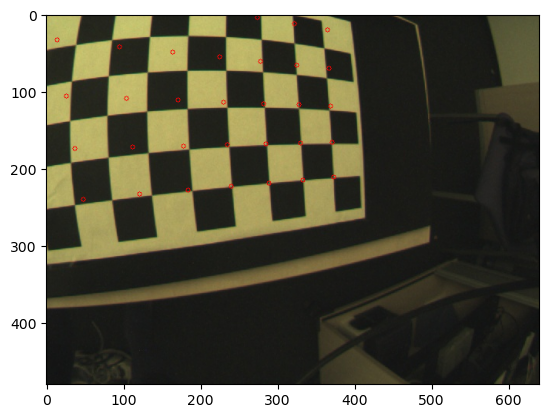

In [107]:
os.makedirs(name=f'results/no_distortion', exist_ok=True)
os.makedirs(name=f'results/distortion', exist_ok=True)

base_folder = './data/'

# Load the data
# There are 25 views/or images/ and 40 3D points per view
data = io.loadmat('./data/calib.mat')

# 3D points in the world coordinate system
x_3d_w = data['x_3d_w'] # shape=[25, 40, 3]

# Translation vector: as the world origin is seen from the camera coordinates
t_vecs = data['translation_vecs'] # shape=[25, 3, 1]

# Rotation matrices: converts coordinates from world to camera
rot_mats = data['rot_mats'] # shape=[25, 3, 3]

# Five distortion coefficients
dist_coef = data['distortion_params'] # shape=[5, 1]

# K matrix of the cameras
k_matrix = data['k_mat'] # shape=[3, 3]

# Images corresponding to the 3D points
imgs_list = [cv.imread(base_folder+str(i).zfill(5)+'.jpg') for i in range(t_vecs.shape[0])]
imgs = np.asarray(imgs_list) # shape=[25, 480, 640, 3]

#Call project_and_draw twice: once without and once with distortion modelling
print(x_3d_w[0,10])
img = project_and_draw(imgs[0], x_3d_w[0], (0, 0, 255), k_matrix, rot_mats[0], t_vecs[0])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# project_and_draw()

# without_distortion = Image.open('results/no_distortion/')
# display(without_distortion)

# with_distortion = Image.open('results/distortion/')
# display(with_distortion)
